In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# import m2cgen as m2c
import joblib
import pickle
import glob
import sys
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support

print("done")



done


In [5]:
files = glob.glob("clean_csv/*.csv")
print(files)
for file in files:
    print(file.split("\\")[1])

['clean_csv\\in01-bus-window.csv', 'clean_csv\\in02-in-takapuna-library-children.csv', 'clean_csv\\in03-in-takapuna-library-general.csv', 'clean_csv\\in04-classroom.csv', 'clean_csv\\in05-in-building-by-window1150.csv', 'clean_csv\\out01-cbd-walk.csv', 'clean_csv\\out02-walk-primary.csv', 'clean_csv\\out03-park.csv', 'clean_csv\\out04-tree-shade.csv', 'clean_csv\\out05-walk-primary.csv', 'clean_csv\\out06-out-takapuna-cbd.csv', 'clean_csv\\out07-cbd-walk-1619.csv', 'clean_csv\\out08-cbd-walk-1240.csv', 'clean_csv\\out09-albert-park-1421.csv', 'clean_csv\\out10-cbd-walk-1258.csv', 'clean_csv\\out11-under-clear-ceiling-1308.csv', 'clean_csv\\out12-walk-afterschool.csv', 'clean_csv\\out13-walk-toschool.csv']
in01-bus-window.csv
in02-in-takapuna-library-children.csv
in03-in-takapuna-library-general.csv
in04-classroom.csv
in05-in-building-by-window1150.csv
out01-cbd-walk.csv
out02-walk-primary.csv
out03-park.csv
out04-tree-shade.csv
out05-walk-primary.csv
out06-out-takapuna-cbd.csv
out07-cb

# Preprocessing



In [17]:
# Import data to use as training data

dataframes_in = []
dataframes_out = []
files = glob.glob("clean_csv/*.csv")
print(files)
for filename in files:
    df = pd.read_csv(filename,  index_col=False)
    print(df.head())
    print(filename[10])
    if filename[10] == "i":
        print("in")
        dataframes_in.append(df)
    else:
        print("out")
        dataframes_out.append(df)

in_data = pd.concat(dataframes_in)
out_data = pd.concat(dataframes_out)


['clean_csv\\in01-bus-window.csv', 'clean_csv\\in02-in-takapuna-library-children.csv', 'clean_csv\\in03-in-takapuna-library-general.csv', 'clean_csv\\in04-classroom.csv', 'clean_csv\\in05-in-building-by-window1150.csv', 'clean_csv\\out01-cbd-walk.csv', 'clean_csv\\out02-walk-primary.csv', 'clean_csv\\out03-park.csv', 'clean_csv\\out04-tree-shade.csv', 'clean_csv\\out05-walk-primary.csv', 'clean_csv\\out06-out-takapuna-cbd.csv', 'clean_csv\\out07-cbd-walk-1619.csv', 'clean_csv\\out08-cbd-walk-1240.csv', 'clean_csv\\out09-albert-park-1421.csv', 'clean_csv\\out10-cbd-walk-1258.csv', 'clean_csv\\out11-under-clear-ceiling-1308.csv', 'clean_csv\\out12-walk-afterschool.csv', 'clean_csv\\out13-walk-toschool.csv']
    timestamp  uv  accelX  accelY  accelZ    r    g    b     c  colorTemp  \
0  1712470902   0    -487    1873    6644  127  142  175   356       7404   
1  1712470906   0   -1746   -1469    8748  335  501  464  1319       6668   
2  1712470908   1   -2418     295    8408   67  113  1

C:\Users\lucia\AppData\Local\Temp\ipykernel_16784\1508858384.py:8: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(filename,  index_col=False)


In [18]:
# Outdoors is positive
print(in_data.shape)
print(out_data.shape)
in_data["target"] = 0
out_data["target"] = 1

all_data = pd.concat([in_data, out_data])

(1506, 12)
(2915, 12)


In [19]:
all_data.head()

,timestamp,uv,accelX,accelY,accelZ,r,g,b,c,colorTemp,lux,target
0,1.712471e+09,0,-487,1873,6644,127,142,175,356,7404,54,0
1,1.712471e+09,0,-1746,-1469,8748,335,501,464,1319,6668,342,0
2,1.712471e+09,1,-2418,295,8408,67,113,118,298,8101,70,0
3,1.712471e+09,0,-1215,-245,7452,9,11,12,25,7106,5,0
4,1.712471e+09,0,-3068,-286,6818,31,37,39,78,6993,19,0


In [26]:
print(all_data["target"].value_counts())




target
1    2915
0    1506
Name: count, dtype: int64


# Create new features

In [27]:
import math
# accelerometer

all_data['accelN'] = all_data.apply(lambda row: (row.accelX + row.accelY + row.accelZ) / 3, axis=1)
all_data['accelMagnitude'] = all_data.apply(lambda row: row.accelX ** 2 + row.accelY ** 2 + row.accelZ ** 2, axis=1)
all_data['accelXY'] = all_data.apply(lambda row: (row.accelX * row.accelY) ** 2, axis=1)


# rgb vs clear
all_data['red/clear'] = all_data.apply(lambda row: row.r / (row.c + 1), axis=1)
all_data['green/clear'] = all_data.apply(lambda row: row.g /  (row.c + 1), axis=1)
all_data['blue/clear'] = all_data.apply(lambda row: row.b /  (row.c + 1), axis=1)

# rgb versus each other
all_data['red/green'] = all_data.apply(lambda row: row.r / (row.g + 1), axis=1)
all_data['blue/red'] = all_data.apply(lambda row: row.g / (row.r + 1), axis=1)
all_data['blue/green'] = all_data.apply(lambda row: row.b / (row.g + 1), axis=1)

# relative difference of each colour compared to rgbc channels
all_data["(clear-red)/red"] = all_data.apply(lambda row: (row.c - row.r) / (row.r + 1), axis=1)
all_data["(clear-green)/red"] = all_data.apply(lambda row: (row.c - row.g) / (row.r + 1), axis=1)
all_data["(clear-blue)/red"] = all_data.apply(lambda row: (row.c - row.b) / (row.r + 1), axis=1)

all_data["(clear-red)/green"] = all_data.apply(lambda row: (row.c - row.r) / (row.g + 1), axis=1)
all_data["(clear-green)/green"] = all_data.apply(lambda row: (row.c - row.g) / (row.g + 1), axis=1)
all_data["(clear-blue)/green"] = all_data.apply(lambda row: (row.c - row.b) / (row.g + 1), axis=1)

all_data["(clear-red)/blue"] = all_data.apply(lambda row: (row.c - row.r) / (row.b + 1), axis=1)
all_data["(clear-green)/blue"] = all_data.apply(lambda row: (row.c - row.g) / (row.b + 1), axis=1)
all_data["(clear-blue)/blue"] = all_data.apply(lambda row: (row.c - row.b) / (row.b + 1), axis=1)

all_data["(clear-red)/clear"] = all_data.apply(lambda row: (row.c - row.r) / (row.c + 1), axis=1)
all_data["(clear-green)/clear"] = all_data.apply(lambda row: (row.c - row.g) / (row.c + 1), axis=1)
all_data["(clear-blue)/clear"] = all_data.apply(lambda row: (row.c - row.b) / (row.c + 1), axis=1)


# rgb vs clear
all_data['red/clear'] = all_data.apply(lambda row: row.r / (row.c + 1), axis=1)
all_data['green/clear'] = all_data.apply(lambda row: row.g /  (row.c + 1), axis=1)
all_data['blue/clear'] = all_data.apply(lambda row: row.b /  (row.c + 1), axis=1)


# log(rgb) vs log(clear)
all_data['log(red)/log(clear)'] = all_data.apply(lambda row: math.log(row.r + 1)/ math.log(row.c + 1), axis=1)
all_data['log(green)/log(clear)'] = all_data.apply(lambda row: math.log(row.g + 1) / math.log(row.c + 1), axis=1)
all_data['log(blue)/log(clear)'] = all_data.apply(lambda row: math.log(row.b + 1) / math.log(row.c + 1), axis=1)

#difference between clear and rgb
all_data['log(red)/log(clear)'] = all_data.apply(lambda row: math.log(row.r + 1)/ math.log(row.c + 1), axis=1)


#log(rgb) versus each other
all_data['log(red)/log(green)'] = all_data.apply(lambda row: math.log(row.r + 1) / math.log(row.g + 1), axis=1)
all_data['log(blue)/log(red)'] = all_data.apply(lambda row: math.log(row.g + 1) / math.log(row.r + 1), axis=1)
all_data['log(blue)/log(green)'] = all_data.apply(lambda row: math.log(row.b + 1) / math.log(row.g + 1), axis=1)

# sqrt(rgb) vs sqrt(clear)
all_data['sqrt(red)/sqrt(clear)'] = all_data.apply(lambda row: math.sqrt(row.r + 1)/ math.sqrt(row.c + 1), axis=1)
all_data['sqrt(green)/sqrt(clear)'] = all_data.apply(lambda row: math.sqrt(row.g + 1) / math.sqrt(row.c + 1), axis=1)
all_data['sqrt(blue)/sqrt(clear)'] = all_data.apply(lambda row: math.sqrt(row.b + 1) / math.sqrt(row.c + 1), axis=1)

#sqrt(rgb) vs each other
all_data['sqrt(red)/sqrt(green)'] = all_data.apply(lambda row: math.sqrt(row.r + 1) / math.sqrt(row.g + 1), axis=1)
all_data['sqrt(blue)/sqrt(red)'] = all_data.apply(lambda row: math.sqrt(row.g + 1) / math.sqrt(row.r + 1), axis=1)
all_data['sqrt(blue)/sqrt(green)'] = all_data.apply(lambda row: math.sqrt(row.b + 1) / math.sqrt(row.g + 1), axis=1)


# uv vs lux
all_data['uv/lux'] = all_data.apply(lambda row: row.lux / (row.c + 1), axis=1)
all_data['e^(uv/lux)'] = all_data.apply(lambda row: math.exp (row.lux / (row.c + 1)), axis=1)




In [28]:
X = all_data.drop(['timestamp', 'target'], axis=1)
y = all_data['target']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 512, test_size=0.1)
column_names = list(X.columns)
print(X_train.head())
print(column_names)

      uv  accelX  accelY  accelZ      r      g      b      c  colorTemp  \
59    17   -1140   -1813    5271  25233  26069  29138  60179       6186   
670    4   -1242    1419    6852   8687   9951  11479  24436       7020   
8     18    4666    4695   11801  16810  17892  19579  41211       6227   
32     1   -1071     -12    8235     68     79    101    210       7766   
101  131     791   -1509    6387  65535  65535  65535  65535          0   

       lux  ...  log(blue)/log(red)  log(blue)/log(green)  \
59   11627  ...            1.003216              1.010945   
670   4484  ...            1.014976              1.015516   
8     8452  ...            1.006411              1.009201   
32      28  ...            1.034935              1.055442   
101  34196  ...            1.000000              1.000000   

     sqrt(red)/sqrt(clear)  sqrt(green)/sqrt(clear)  sqrt(blue)/sqrt(clear)  \
59                0.647541                 0.658180                0.695843   
670               0.5962

# Useful functions and values for final evaluation

In [7]:
#initializing useful lists
accuracies = {"Test": {}, "Train": {}}
precisions = {"Test": {}, "Train": {}}
recall = {"Test": {}, "Train": {}}
f_score = {"Test": {}, "Train": {}}

def set_precisions_recall_f_score(y_test, test_predictions, y_train, train_predictions, name):
    test_precision, test_recall, test_f_score, _ = precision_recall_fscore_support(y_test, test_predictions)
    train_precision, train_recall, train_f_score, _ = precision_recall_fscore_support(y_train, train_predictions)


    print(name, 1 - test_precision, 1 - test_recall, 1 - test_f_score)
    print(name, 1 - train_precision, 1 - train_recall, 1 - train_f_score)

    precisions["Test"][name] = test_precision
    precisions["Train"][name] = train_precision

    recall["Test"][name] = test_recall
    recall["Train"][name] = train_recall

    f_score["Test"][name] = test_f_score
    f_score["Train"][name] = train_f_score

def set_accuracies(name, train_accuracy, test_accuracy):
    accuracies["Train"][name] = train_accuracy
    accuracies["Test"][name] = test_accuracy


# Classifiers

Decision Tree [0.01351351 0.03043478] [0.02341137 0.01762115] [0.01848739 0.02407002]
Decision Tree [0. 0.] [0. 0.] [0. 0.]


[Text(0.673469387755102, 0.9583333333333334, 'b <= 4204.0\ngini = 0.483\nsamples = 1577\nvalue = [935, 642]'),
 Text(0.4557823129251701, 0.875, 'c <= 826.0\ngini = 0.259\nsamples = 1100\nvalue = [932, 168]'),
 Text(0.2925170068027211, 0.7916666666666666, 'accelZ <= 3856.5\ngini = 0.064\nsamples = 152\nvalue = [5, 147]'),
 Text(0.23809523809523808, 0.7083333333333334, 'gini = 0.0\nsamples = 4\nvalue = [4, 0]'),
 Text(0.3469387755102041, 0.7083333333333334, 'light <= 53.0\ngini = 0.013\nsamples = 148\nvalue = [1, 147]'),
 Text(0.2925170068027211, 0.625, 'gini = 0.0\nsamples = 147\nvalue = [0, 147]'),
 Text(0.4013605442176871, 0.625, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.6190476190476191, 0.7916666666666666, 'colorTemp <= 6488.0\ngini = 0.043\nsamples = 948\nvalue = [927, 21]'),
 Text(0.564625850340136, 0.7083333333333334, 'accelY <= -6841.5\ngini = 0.025\nsamples = 939\nvalue = [927, 12]'),
 Text(0.5102040816326531, 0.625, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(0

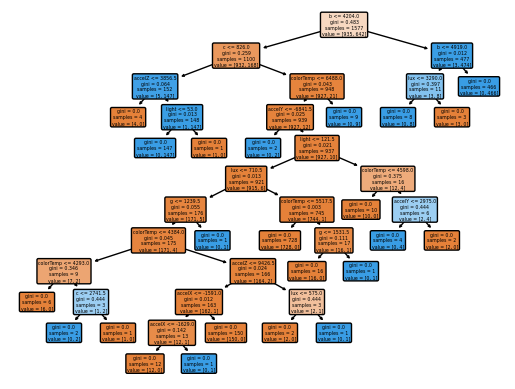

In [8]:
dTree = DecisionTreeClassifier(random_state = 512)

dTree.fit(x_train, y_train)

test_score = dTree.score(x_test, y_test)
train_score = dTree.score(x_train, y_train)
# print(f"A Decision Tree classifier running on the breast cancer dataset from sklearn gives a probility of{test_score * 100: .3f}% on the training data and a probability of{train_score * 100: .3f}%.")

test_predictions = dTree.predict(x_test)
train_predictions = dTree.predict(x_train)

name = "Decision Tree"
set_accuracies(name, train_score, test_score)
set_precisions_recall_f_score(y_test, test_predictions, y_train, train_predictions, name)


# plt.figure(figsize=(15, 7.5))
plot_tree(dTree, filled=True, rounded = True, feature_names=X.columns.tolist())



In [21]:
import sys
!{sys.executable} -m pip install xgboost


Defaulting to user installation because normal site-packages is not writeable


In [31]:

from xgboost import XGBClassifier, plot_importance

xgboost_param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1]
}


xgb_model = XGBClassifier(random_state = 42)
xgb_grid_search = GridSearchCV(xgb_model, xgboost_param_grid, cv=5)
xgb_grid_search.fit(X_train, y_train) 

Best set of hyperparameters:  {'learning_rate': 0.1, 'max_depth': 7, 'subsample': 0.7}
Best score:  0.9942169969343574


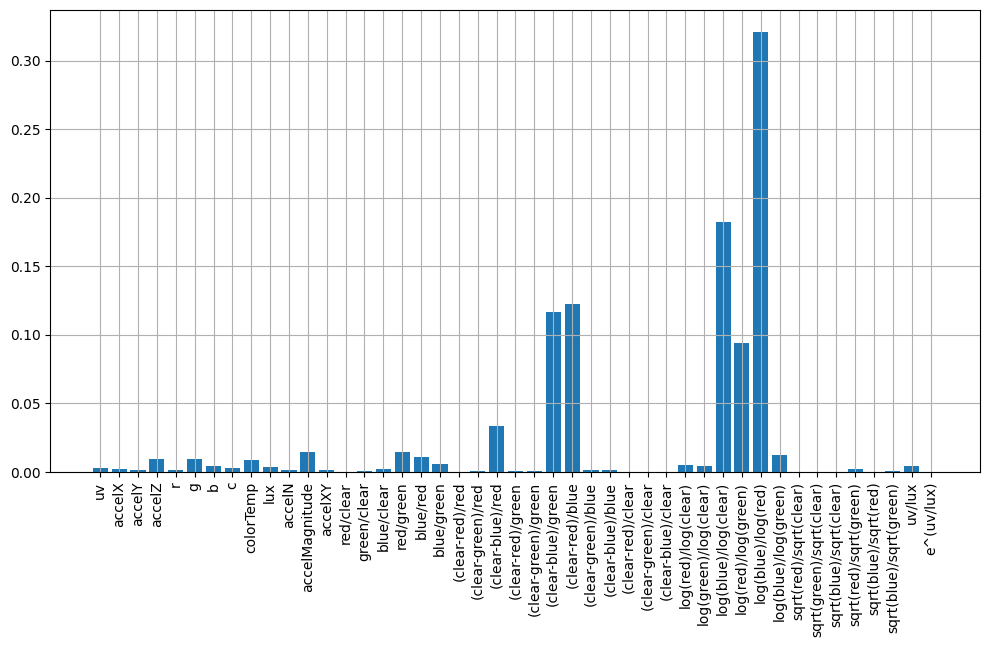

uv: 0.003
accelZ: 0.009
g: 0.009
b: 0.004
c: 0.003
colorTemp: 0.009
lux: 0.003
accelMagnitude: 0.015
blue/clear: 0.002
red/green: 0.014
blue/red: 0.011
blue/green: 0.006
(clear-blue)/red: 0.034
(clear-blue)/green: 0.117
(clear-red)/blue: 0.123
log(red)/log(clear): 0.005
log(green)/log(clear): 0.004
log(blue)/log(clear): 0.182
log(red)/log(green): 0.094
log(blue)/log(red): 0.321
log(blue)/log(green): 0.012
uv/lux: 0.004


In [49]:

print("Best set of hyperparameters: ", xgb_grid_search.best_params_)
print("Best score: ", xgb_grid_search.best_score_)

feature_importances = xgb_grid_search.best_estimator_.feature_importances_

fig = plt.figure(figsize=(12,6))
plt.bar(column_names, feature_importances)
plt.xticks(rotation=90)
plt.grid()
plt.show()

for feature, importance in zip(column_names, feature_importances):
    if importance > 0.002:
        print(f"{feature}: {importance:.3f}")



In [9]:
bagging = BaggingClassifier(random_state = 512)
bagging.fit(x_train, y_train)

test_score = bagging.score(x_test, y_test)
train_score = bagging.score(x_train, y_train)




test_predictions = bagging.predict(x_test)
train_predictions = bagging.predict(x_train)

name = "Bagging"
set_accuracies(name, train_score, test_score)
set_precisions_recall_f_score(y_test, test_predictions, y_train, train_predictions, name)

Bagging [0.0166113  0.01333333] [0.01003344 0.02202643] [0.01333333 0.01769912]
Bagging [0.00106838 0.        ] [0.         0.00155763] [0.00053447 0.00077942]


In [10]:
adaboost = AdaBoostClassifier(random_state=512)
adaboost.fit(x_train, y_train)

test_score = adaboost.score(x_test, y_test)
train_score = adaboost.score(x_train, y_train)

test_predictions = adaboost.predict(x_test)
train_predictions = adaboost.predict(x_train)

name = "Adaboost"
set_accuracies(name, train_score, test_score)
set_precisions_recall_f_score(y_test, test_predictions, y_train, train_predictions, name)


Adaboost [0.01333333 0.01327434] [0.01003344 0.01762115] [0.01168614 0.01545254]
Adaboost [0. 0.] [0. 0.] [0. 0.]


In [53]:
rf_param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'max_features': ['sqrt'],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10],
    'n_estimators': [100, 300]
}


rf_model = RandomForestClassifier(random_state=42)
rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=5)

rf_grid_search.fit(X_train, y_train) 

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10],
                         'n_estimators': [100, 300]})

Best set of hyperparameters:  {'bootstrap': True, 'max_depth': 80, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 100}
Best score:  0.9944679371701273


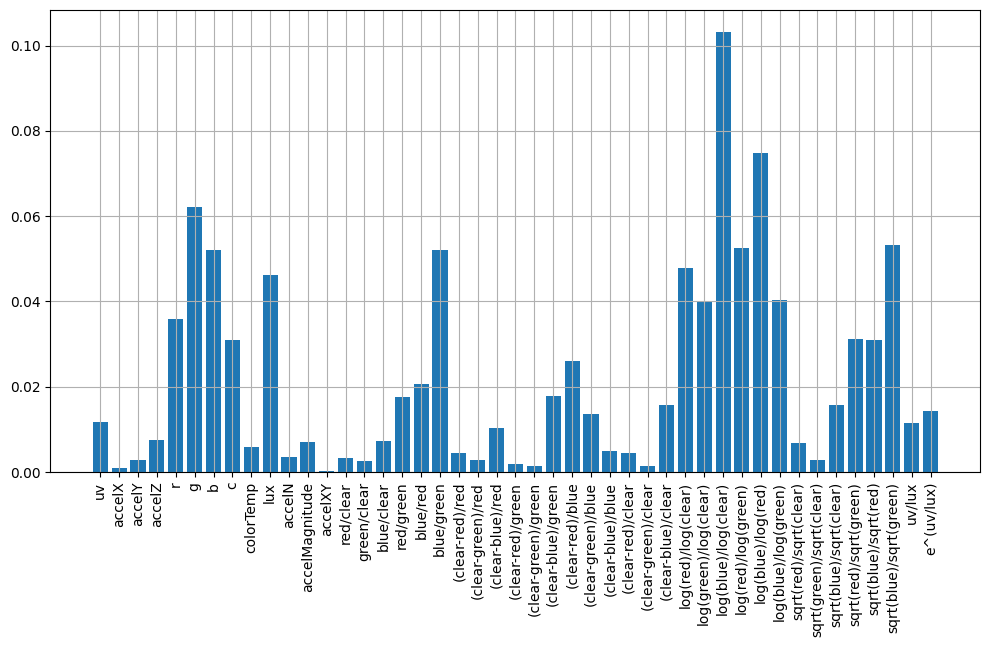

uv: 0.012
accelY: 0.003
accelZ: 0.008
r: 0.036
g: 0.062
b: 0.052
c: 0.031
colorTemp: 0.006
lux: 0.046
accelN: 0.003
accelMagnitude: 0.007
red/clear: 0.003
green/clear: 0.003
blue/clear: 0.007
red/green: 0.018
blue/red: 0.021
blue/green: 0.052
(clear-red)/red: 0.004
(clear-green)/red: 0.003
(clear-blue)/red: 0.010
(clear-blue)/green: 0.018
(clear-red)/blue: 0.026
(clear-green)/blue: 0.014
(clear-blue)/blue: 0.005
(clear-red)/clear: 0.004
(clear-blue)/clear: 0.016
log(red)/log(clear): 0.048
log(green)/log(clear): 0.040
log(blue)/log(clear): 0.103
log(red)/log(green): 0.053
log(blue)/log(red): 0.075
log(blue)/log(green): 0.040
sqrt(red)/sqrt(clear): 0.007
sqrt(green)/sqrt(clear): 0.003
sqrt(blue)/sqrt(clear): 0.016
sqrt(red)/sqrt(green): 0.031
sqrt(blue)/sqrt(red): 0.031
sqrt(blue)/sqrt(green): 0.053
uv/lux: 0.012
e^(uv/lux): 0.014


In [54]:

print("Best set of hyperparameters: ", rf_grid_search.best_params_)
print("Best score: ", rf_grid_search.best_score_)

feature_importances = rf_grid_search.best_estimator_.feature_importances_

fig = plt.figure(figsize=(12,6))
plt.bar(column_names, feature_importances)
plt.xticks(rotation=90)
plt.grid()
plt.show()

for feature, importance in zip(column_names, feature_importances):
    if importance > 0.002:
        print(f"{feature}: {importance:.3f}")



In [12]:


nb_model = GaussianNB()
nb_model.fit(X, y_train)

nb_scores = cross_val_score(nb_model, X_train, y_train, cv = 5, scoring = "f1")
nb_cv_avg = np.mean(nb_scores)

print("Best score: ", nb_cv_avg.best_score_)

Naive Bayes [0.14825581 0.03296703] [0.02006689 0.2246696 ] [0.08864697 0.1393643 ]
Naive Bayes [0.14661654 0.05263158] [0.02887701 0.24299065] [0.09154577 0.15844156]


In [56]:
# SVM
from sklearn.svm import SVC

svm_param_grid = {'C': [0.1, 1, 10, 100,],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf', "linear", "poly", "sigmoid"]} 

svm_model = SVC()
svm_grid = GridSearchCV(svm_model, svm_param_grid, cv = 5, refit = True)
svm_grid.fit(X_train, y_train)


In [ ]:

print("Best set of hyperparameters: ", svm_param_grid.best_params_)
print("Best score: ", svm_param_grid.best_score_)

feature_importances = xgb_grid_search.best_estimator_.coef_

fig = plt.figure(figsize=(12,6))
plt.bar(column_names, feature_importances)
plt.xticks(rotation=90)
plt.grid()
plt.show()

# for feature, importance in zip(column_names, feature_importances):
#     if importance > 0.002:
#         print(f"{feature}: {importance:.3f}")



# Benchmarks
Comparing tables that compare the Accuracy, Precision and Recall of the different models.

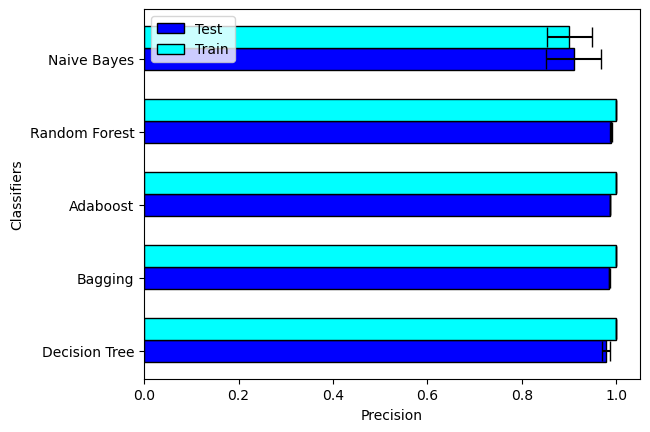

{'Test': {'Decision Tree': array([0.98648649, 0.96956522]), 'Bagging': array([0.9833887 , 0.98666667]), 'Adaboost': array([0.98666667, 0.98672566]), 'Random Forest': array([0.98671096, 0.99111111]), 'Naive Bayes': array([0.85174419, 0.96703297])}, 'Train': {'Decision Tree': array([1., 1.]), 'Bagging': array([0.99893162, 1.        ]), 'Adaboost': array([1., 1.]), 'Random Forest': array([0.99893162, 1.        ]), 'Naive Bayes': array([0.85338346, 0.94736842])}}


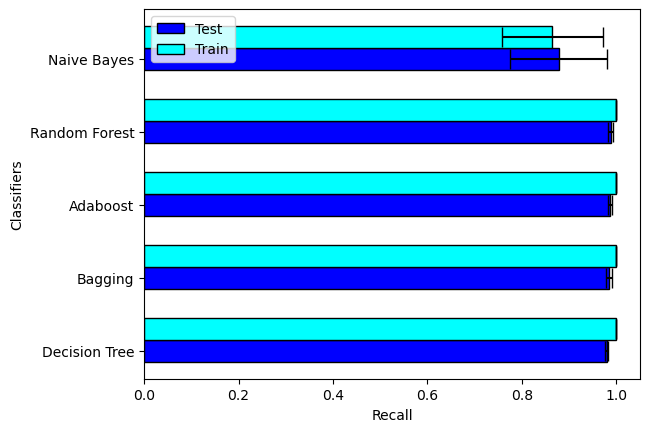

{'Test': {'Decision Tree': array([0.97658863, 0.98237885]), 'Bagging': array([0.98996656, 0.97797357]), 'Adaboost': array([0.98996656, 0.98237885]), 'Random Forest': array([0.99331104, 0.98237885]), 'Naive Bayes': array([0.97993311, 0.7753304 ])}, 'Train': {'Decision Tree': array([1., 1.]), 'Bagging': array([1.        , 0.99844237]), 'Adaboost': array([1., 1.]), 'Random Forest': array([1.        , 0.99844237]), 'Naive Bayes': array([0.97112299, 0.75700935])}}


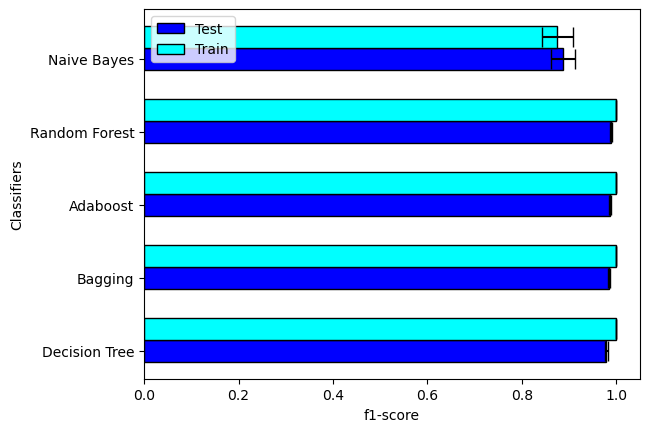

{'Test': {'Decision Tree': array([0.98151261, 0.97592998]), 'Bagging': array([0.98666667, 0.98230088]), 'Adaboost': array([0.98831386, 0.98454746]), 'Random Forest': array([0.99      , 0.98672566]), 'Naive Bayes': array([0.91135303, 0.8606357 ])}, 'Train': {'Decision Tree': array([1., 1.]), 'Bagging': array([0.99946553, 0.99922058]), 'Adaboost': array([1., 1.]), 'Random Forest': array([0.99946553, 0.99922058]), 'Naive Bayes': array([0.90845423, 0.84155844])}}


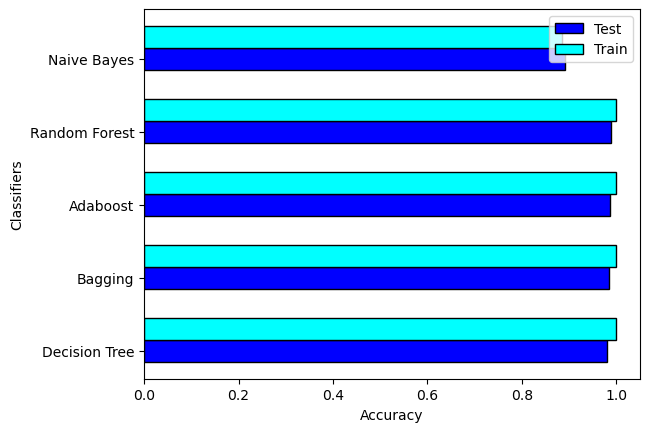

{'Test': {'Decision Tree': 0.9790874524714829, 'Bagging': 0.9847908745247148, 'Adaboost': 0.9866920152091255, 'Random Forest': 0.9885931558935361, 'Naive Bayes': 0.8916349809885932}, 'Train': {'Decision Tree': 1.0, 'Bagging': 0.9993658845909955, 'Adaboost': 1.0, 'Random Forest': 0.9993658845909955, 'Naive Bayes': 0.8839568801521877}}


In [13]:
def draw_table_w_conf_int(data, statistic):
    bar_width = 0.3

    classifiers = list(data["Test"].keys())
    test_results = list(data["Test"].values())
    train_results = list(data["Train"].values())
    test_exp = []
    test_err = []
    for test_result in test_results:
        test_exp.append(test_result[0] + (test_result[1] - test_result[0]) / 2)
        test_err.append(abs(test_result[1] - test_result[0]) / 2)

    train_exp = []
    train_err = []
    for train_result in train_results:
        train_exp.append(train_result[0] + (train_result[1] - train_result[0]) / 2)
        train_err.append(abs(train_result[1] - train_result[0]) / 2)
    
    r1 = np.arange(len(test_exp))
    r2 = [x + bar_width for x in r1]

    plt.barh(r1, test_exp, height = bar_width, color = 'blue', edgecolor = 'black', xerr=test_err, capsize=7, label="Test")

    plt.barh(r2, train_exp, height = bar_width, color = 'cyan', edgecolor = 'black', xerr=train_err, capsize=7, label='Train')

    plt.yticks([r for r in range(len(test_exp))], classifiers)

    plt.xlabel(f"{statistic}")
    plt.ylabel('Classifiers')

    plt.legend()
    plt.show()


def draw_table(data, statistic):
    bar_width = 0.3

    classifiers = list(data["Test"].keys())
    test_results = list(data["Test"].values())
    train_results = list(data["Train"].values())

    
    r1 = np.arange(len(classifiers))
    r2 = [x + bar_width for x in r1]

    plt.barh(r1, test_results, height = bar_width, color = 'blue', edgecolor = 'black', capsize=7, label="Test")

    plt.barh(r2, train_results, height = bar_width, color = 'cyan', edgecolor = 'black', capsize=7, label='Train')

    plt.yticks([r for r in range(len(classifiers))], classifiers)

    plt.xlabel(f"{statistic}")
    plt.ylabel('Classifiers')

    plt.legend()
    plt.show()

    """
    classifiers = list(data.keys())
    results = list(data.values())
    print(classifiers, results)

    fig = plt.figure(figsize = (10, 5))
 
    # creating the bar plot
    plt.barh(classifiers, results, color ="navy")
    
    
    plt.ylabel("Classifier")
    plt.title(f"Comparing 1 - (The {statistic}) With Each Classifier For {datatype} Data")
    plt.show()"""

draw_table_w_conf_int(precisions, "Precision")
print(precisions)

draw_table_w_conf_int(recall, "Recall")
print(recall)

draw_table_w_conf_int(f_score, "f1-score")
print(f_score)

draw_table(accuracies, "Accuracy")
print(accuracies)





    

## ROC Curve

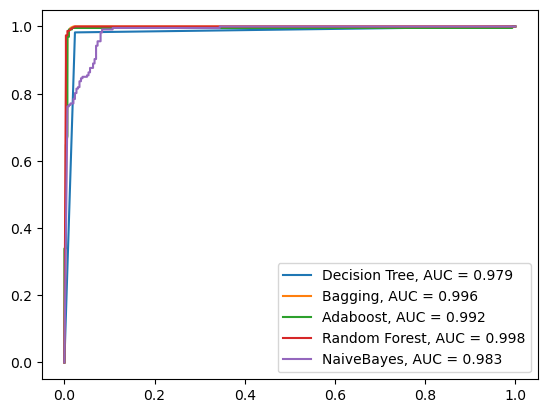

In [14]:
plt.figure(0).clf()

classifiers = {
    "Decision Tree": dTree,
    # "XGBoost": xgbClassifier,
    "Bagging": bagging,
    "Adaboost": adaboost,
    "Random Forest": random_forest,
    "NaiveBayes": naive_bayes
}

for name, classifier in classifiers.items():
    y_pred_probs = classifier.predict_proba(x_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
    auc = roc_auc_score(y_test, y_pred_probs)
    plt.plot(fpr, tpr, label = f"{name}, AUC = {auc:.3f}")


plt.legend()

In [12]:
# m2cgen

dart_model = []

# naive_bayes_dart = m2c.export_to_dart(naive_bayes)
# random_forest_dart = m2c.export_to_dart(random_forest)
# xgbClassifier_dart = m2c.export_to_dart(xgbClassifier)
# adaboost_dart = m2c.export_to_dart(adaboost)

# with open('random_forest.dart', 'w') as f:
#     code = m2c.export_to_dart(random_forest)
#     f.write(code)
# with open('xgboost.dart', 'w') as f:
#     code = m2c.export_to_dart(xgbClassifier)
#     f.write(code)
# with open('xgboost.py', 'w') as f:
#     code = m2c.export_to_python(xgbClassifier)
#     f.write(code)
# with open('decision_tree.dart', 'w') as f:
#     code = m2c.export_to_dart(dTree)
#     f.write(code)
# import pickle



# with open('xgboost.pkl', 'wb') as file:

#     pickle.dump(xgbClassifier, file )



joblib.dump(xgbClassifier, "xgboost_model.pkl")

['xgboost_model.pkl']

In [13]:
# joblib.dump(x_train.columns, 'column_order.txt')